Имеются данные пациентов для предсказания риска сердечных приступов. Тестовый датасет, не содержащий правильных ответов. Задача - разработать модель для предсказания высокого или низкого риска поражения сердцана на тестовой выборке. 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import numpy as np
import shap

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline 


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


C:\Users\tanta\miniconda3\envs\heart_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка и подготовка данных

In [2]:
file_id_1 = "1QYkOGKlHtugjJcccN7UhwPAvfsfyck7C"
url1 = f"https://drive.google.com/uc?id={file_id_1}"

train_df = pd.read_csv(url1, index_col=0)
pd.set_option('display.max_columns', None)
train_df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [3]:
file_id_2 = "1qJduj_-_nWCNhfTdICReepAbUs8OHC_Y"
url2 = f"https://drive.google.com/uc?id={file_id_2}"

test_df = pd.read_csv(url2, index_col=0)
test_df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


Представленные данные - это данные пациентов для предсказания риска сердечных приступов, в которых сродержится информация об ннтропометрических параметрах(вес, возраст, рост), привычках, давлении, наличии хронических забролеваний и результаты биохимии крови по некоторым показателям


### Поиск дубликатов, пропусков, изучение типа данных

In [4]:
def information (df):
    display(df.head())
    df.info()
    print("\n Количество пропусков:")
    display(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False))
    
    print("\n Количество дубликатов:")
    print(df.duplicated().sum())

In [5]:
information(train_df)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level             

Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64


 Количество дубликатов:
0


Дубликатов нет. Пропуски есть в 243 строках. Посмотрю совпадают ли их id, то есть эти пропуски у одних и тех же людей, или у разных

In [6]:
cols_to_check = [
    "Diabetes",
    "Family History",
    "Smoking",
    "Obesity",
    "Alcohol Consumption",
    "Previous Heart Problems",
    "Medication Use",
    "Stress Level",
    "Physical Activity Days Per Week"
]
missing_rows = train_df[train_df[cols_to_check].isna().any(axis=1)]
missing_ids = missing_rows["id"]
print("Количество строк с пропусками:", len(missing_ids))
display(missing_ids.head())

Количество строк с пропусками: 243


16     9528
90     9640
92     9515
185    9491
188    9448
Name: id, dtype: int64

In [7]:
train_df[train_df['id'].isin(missing_ids)]['Heart Attack Risk (Binary)'].value_counts(normalize=True)

Heart Attack Risk (Binary)
0.0    1.0
Name: proportion, dtype: float64

Получается, что все удалённые строки — это пациенты с низким риском инфаркта

In [8]:
# Посмотрю долю классов до удаления:
train_df['Heart Attack Risk (Binary)'].value_counts(normalize=True)

Heart Attack Risk (Binary)
0.0    0.65308
1.0    0.34692
Name: proportion, dtype: float64

In [9]:
train_df.shape

(8685, 27)

In [10]:
train_df = train_df[~train_df['id'].isin(missing_ids)].reset_index(drop=True)
train_df.shape

(8442, 27)

In [11]:
# Доля классов после удаления:
train_df['Heart Attack Risk (Binary)'].value_counts(normalize=True)

Heart Attack Risk (Binary)
0.0    0.643094
1.0    0.356906
Name: proportion, dtype: float64

В датасете были обнаружены 243 строки с пропусками в 9 ключевых признаках.
Все эти строки принадлежали к классу 0, то есть предположительно "низкий риск".
После анализа было принято решение об их удалении, поскольку восстановить данные невозможно, а объём составляет лишь 2,8% выборки.
Баланс классов после удаления изменился незначительно (класс 0: с 65.3% до 64.3%).

In [12]:
binary_cols = ['Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems', 'Medication Use']
#Проверю точно ли все признаки, которые я определила бинарными, действительно такие:
for col in binary_cols:
    unique_vals = train_df[col].unique()
    print(f"{col}: {sorted(unique_vals)} (n={len(unique_vals)})")

Diabetes: [0.0, 1.0] (n=2)
Family History: [0.0, 1.0] (n=2)
Smoking: [0.0, 1.0] (n=2)
Obesity: [0.0, 1.0] (n=2)
Alcohol Consumption: [0.0, 1.0] (n=2)
Previous Heart Problems: [0.0, 1.0] (n=2)
Medication Use: [0.0, 1.0] (n=2)


In [13]:
#Изменю тип данных бинарных признаков на int:
for col in binary_cols:
    train_df[col] = train_df[col].astype(int)

In [14]:
#Также для категориальных признаков Stress Level и  Physical Activity Days Per Week:
train_df['Stress Level'] = train_df['Stress Level'].astype(int)
train_df['Physical Activity Days Per Week'] = train_df['Physical Activity Days Per Week'].astype(int)

In [15]:
#Для таргето тоже:
train_df['Heart Attack Risk (Binary)'] = train_df['Heart Attack Risk (Binary)'].astype(int)

In [16]:
train_df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,1,0,8,0.225704,0.105948,0.459176,0.979221,3,0.333333,0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,1,0,9,0.289923,0.164217,0.117053,0.515584,3,0.833333,0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,1,1,6,0.550133,0.598745,0.373574,0.012987,2,1.000000,0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,0,1,3,0.330962,0.077605,0.049735,0.131169,0,0.333333,1,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,0,0,8,0.524600,0.341960,0.830405,0.070130,5,1.000000,1,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8442 entries, 0 to 8441
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8442 non-null   float64
 1   Cholesterol                      8442 non-null   float64
 2   Heart rate                       8442 non-null   float64
 3   Diabetes                         8442 non-null   int32  
 4   Family History                   8442 non-null   int32  
 5   Smoking                          8442 non-null   int32  
 6   Obesity                          8442 non-null   int32  
 7   Alcohol Consumption              8442 non-null   int32  
 8   Exercise Hours Per Week          8442 non-null   float64
 9   Diet                             8442 non-null   int64  
 10  Previous Heart Problems          8442 non-null   int32  
 11  Medication Use                   8442 non-null   int32  
 12  Stress Level        

В итоге в тренировочном датасете изменила тип данных бинарных признаков на int

In [18]:
information(test_df)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level               

Diabetes                           31
Family History                     31
Smoking                            31
Obesity                            31
Alcohol Consumption                31
Previous Heart Problems            31
Medication Use                     31
Stress Level                       31
Physical Activity Days Per Week    31
dtype: int64


 Количество дубликатов:
0


Дубликатов нет, пропуски в тех же столбцах. Также посмотрю id строк с пропусками

In [19]:
missing_rows = test_df[test_df[cols_to_check].isna().any(axis=1)]
missing_ids = missing_rows["id"]
print("Количество строк с пропусками:", len(missing_ids))
display(missing_ids.head())

Количество строк с пропусками: 31


27    9613
37    9471
58    9486
60    9391
61    9579
Name: id, dtype: int64

In [20]:
test_df.shape

(966, 26)

In [21]:
test_df = test_df[~test_df['id'].isin(missing_ids)].reset_index(drop=True)
test_df.shape

(935, 26)

Удаленные строки составляют 3,2 % от датасета. Считаю и это удаление не критичным, т.к. не представляется возможным заполнение этих данных.

In [22]:
#Проверю точно ли все признаки, которые я определила бинарными, действительно такие:
for col in binary_cols:
    unique_vals = test_df[col].unique()
    print(f"{col}: {sorted(unique_vals)} (n={len(unique_vals)})")

Diabetes: [0.0, 1.0] (n=2)
Family History: [0.0, 1.0] (n=2)
Smoking: [0.0, 1.0] (n=2)
Obesity: [0.0, 1.0] (n=2)
Alcohol Consumption: [0.0, 1.0] (n=2)
Previous Heart Problems: [0.0, 1.0] (n=2)
Medication Use: [0.0, 1.0] (n=2)


In [23]:
for col in binary_cols:
    test_df[col] = test_df[col].astype(int)

In [24]:
#Также для категориальных признаков Stress Level и  Physical Activity Days Per Week:
test_df['Stress Level'] = test_df['Stress Level'].astype(int)
test_df['Physical Activity Days Per Week'] = test_df['Physical Activity Days Per Week'].astype(int)

In [25]:
test_df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.494382,0.264286,0.062328,0,1,1,1,1,0.361618,2,0,0,8,0.194370,0.587759,0.283490,0.306494,1,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1,0,0,1,0,0.996483,2,1,1,5,0.329888,0.602883,0.467036,0.087013,0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0,1,1,1,0,0.995561,0,0,0,10,0.780075,0.370436,0.409366,0.205195,7,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1,1,1,1,1,0.437277,0,0,0,10,0.785071,0.368242,0.910261,0.163636,0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1,0,1,0,1,0.514920,0,0,0,7,0.070919,0.729578,0.758924,0.580519,5,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              935 non-null    float64
 1   Cholesterol                      935 non-null    float64
 2   Heart rate                       935 non-null    float64
 3   Diabetes                         935 non-null    int32  
 4   Family History                   935 non-null    int32  
 5   Smoking                          935 non-null    int32  
 6   Obesity                          935 non-null    int32  
 7   Alcohol Consumption              935 non-null    int32  
 8   Exercise Hours Per Week          935 non-null    float64
 9   Diet                             935 non-null    int64  
 10  Previous Heart Problems          935 non-null    int32  
 11  Medication Use                   935 non-null    int32  
 12  Stress Level          

**Вывод промежуточный** В датасетах удалены строки с выбросами, изменены некоторые типы данных (для бинарных признаков) с float64 на int64, дубликатов в датасетах нет. В данных явный дисбаланс классов

### Визуализация распределения данных

In [27]:
set(train_df.columns) - set(test_df.columns)

{'Heart Attack Risk (Binary)'}

In [28]:
columns = test_df.columns
display(columns)

Index(['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar',
       'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure',
       'Diastolic blood pressure', 'id'],
      dtype='object')

In [29]:
numeric_cols = ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar',
       'CK-MB', 'Troponin', 'Systolic blood pressure',
       'Diastolic blood pressure']

In [30]:
# Функция построения гистограмм:
def hists(df, numeric_cols):
    for col in numeric_cols:
        plt.figure(figsize=(5, 2))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(col)
        plt.tight_layout()
        plt.show()

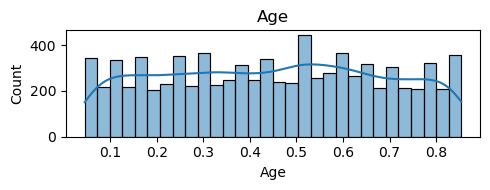

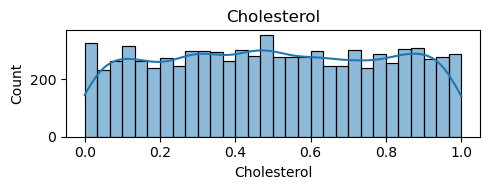

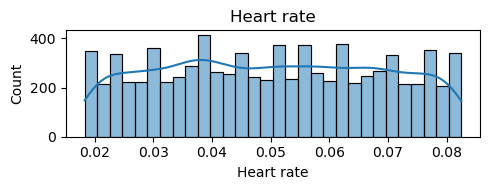

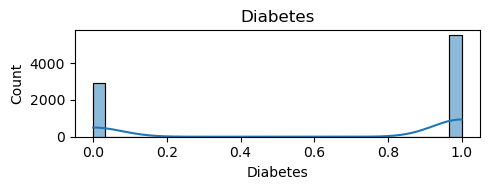

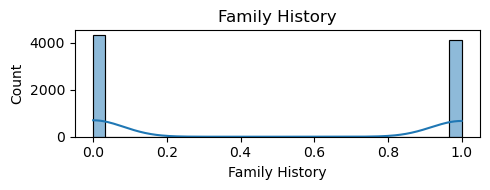

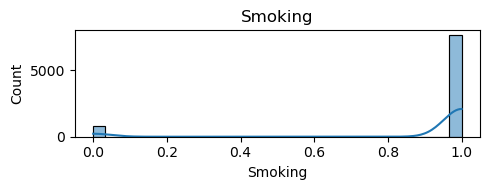

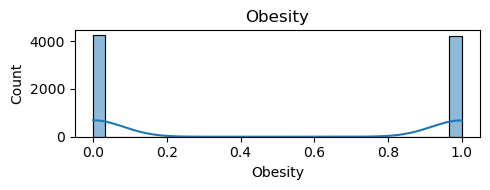

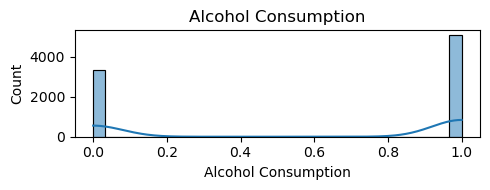

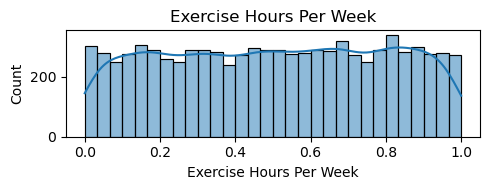

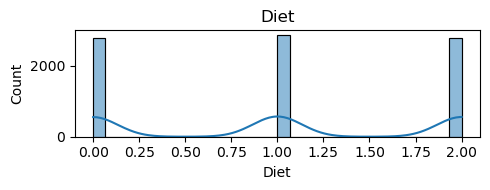

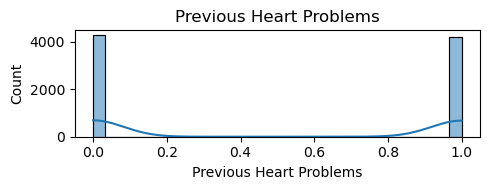

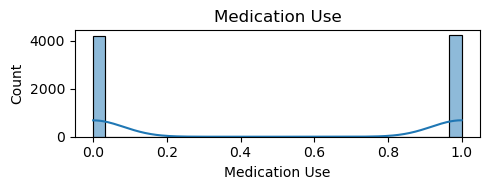

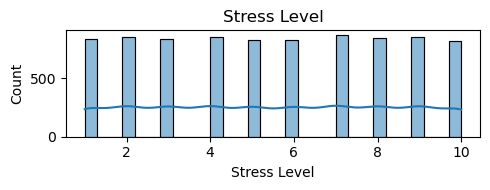

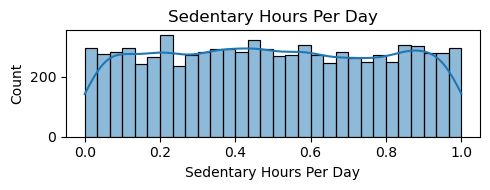

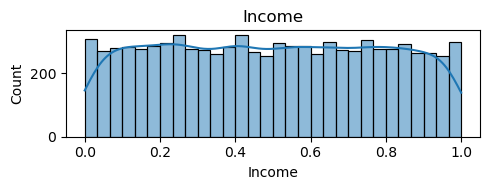

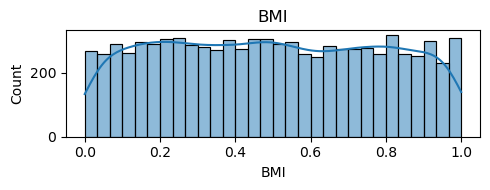

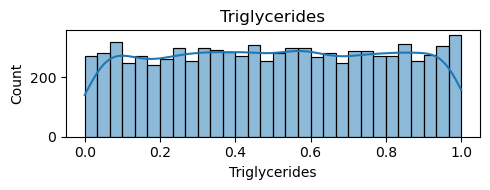

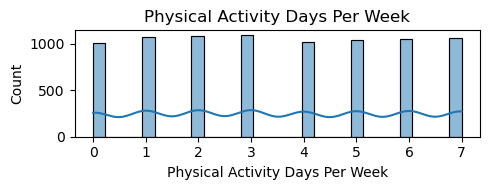

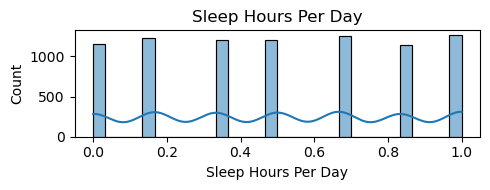

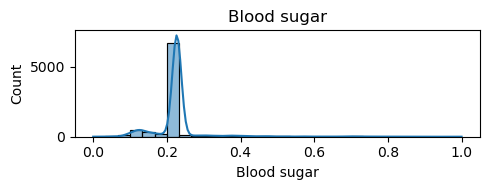

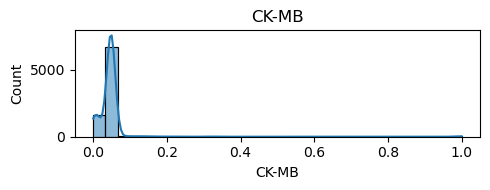

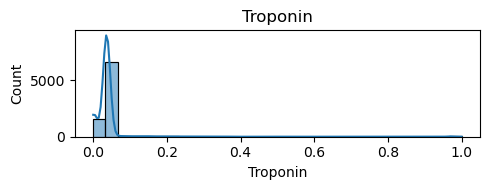

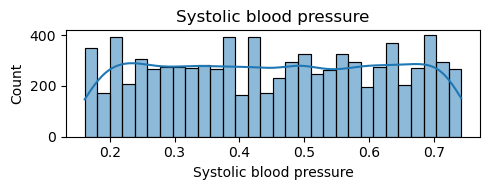

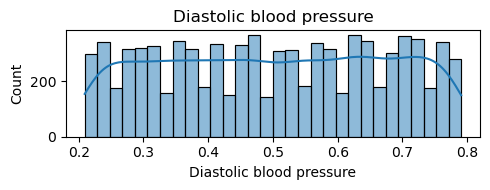

In [31]:
hists(train_df, numeric_cols)

In [32]:
# Функция boxplot для входных признаков:
def plot_boxplots(df, numeric_cols):
    for col in numeric_cols:
        plt.figure(figsize=(6, 3))
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot: {col}')
        plt.tight_layout()
        plt.show()

In [33]:
# Функция boxplot для входных признаков и их распределение по бинарному:
# Хочу постмотреть смещение медиан и информативность признаков
def plot_boxplots_by_target(df, numeric_cols, target_col):
    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=target_col, y=col, data=df)
        plt.title(f'Boxplot: {col} vs {target_col}')
        plt.tight_layout()
        plt.show()

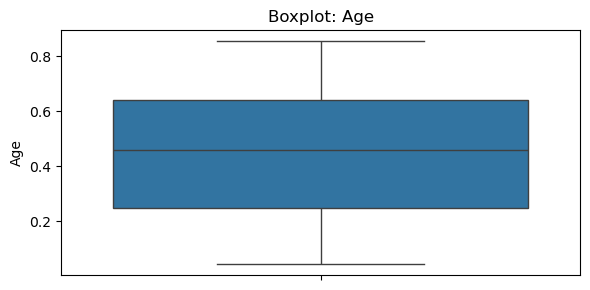

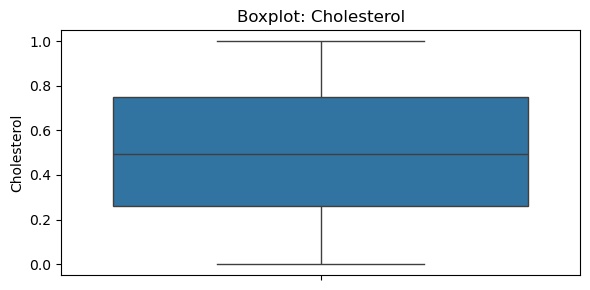

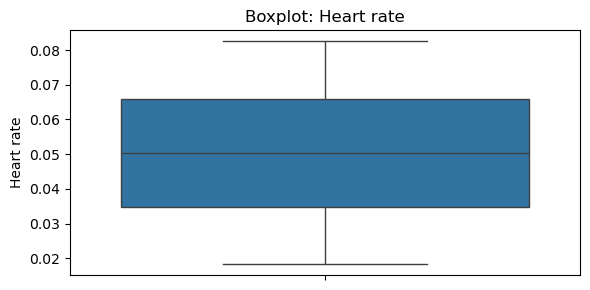

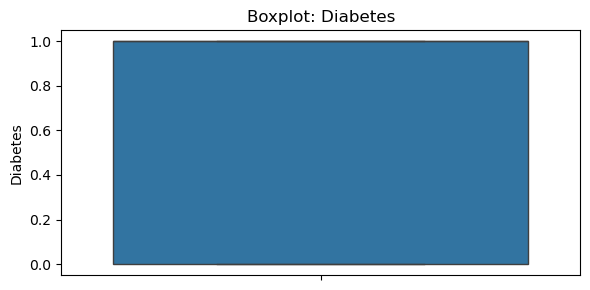

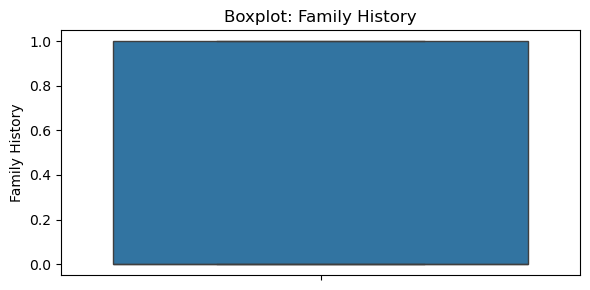

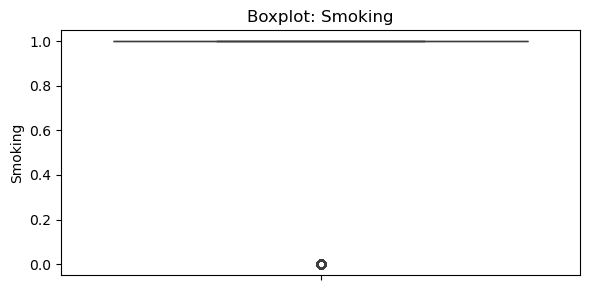

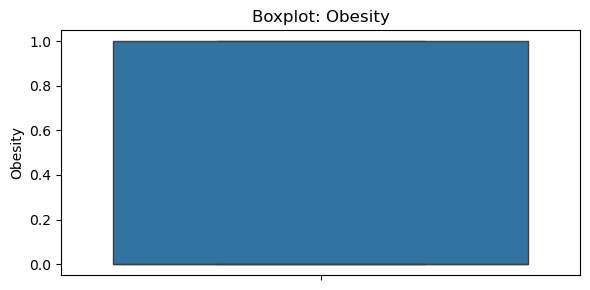

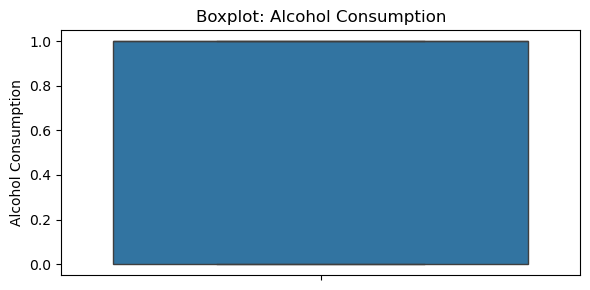

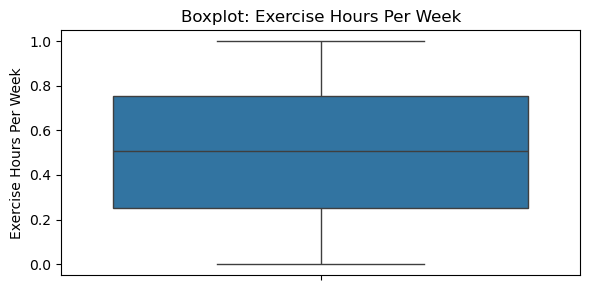

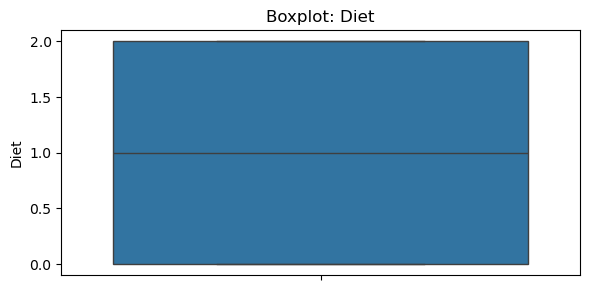

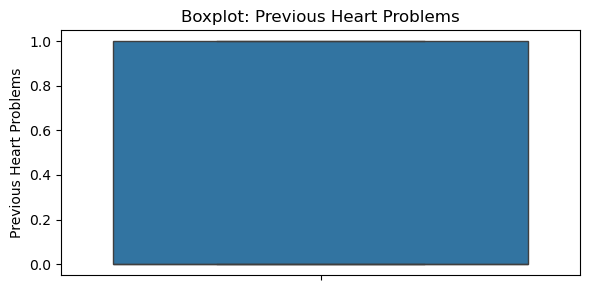

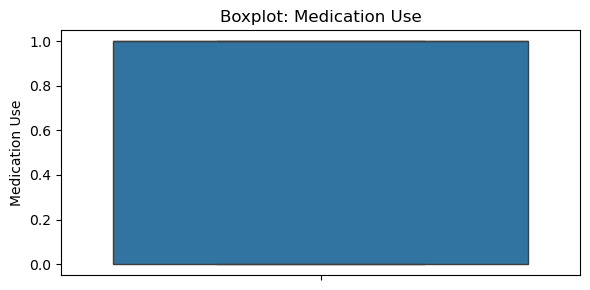

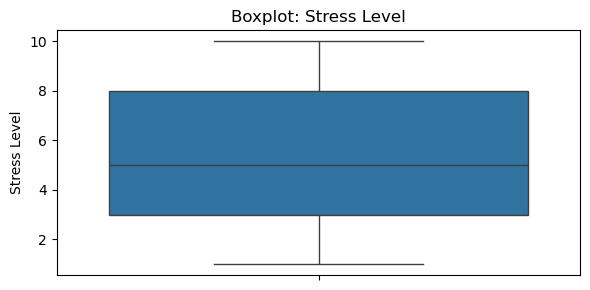

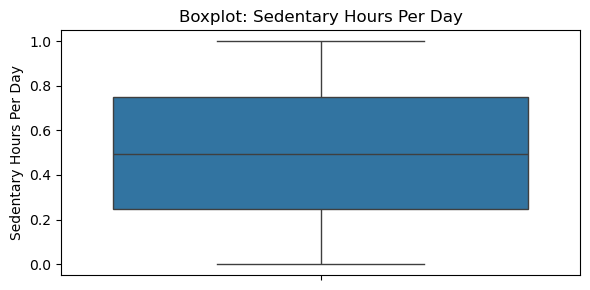

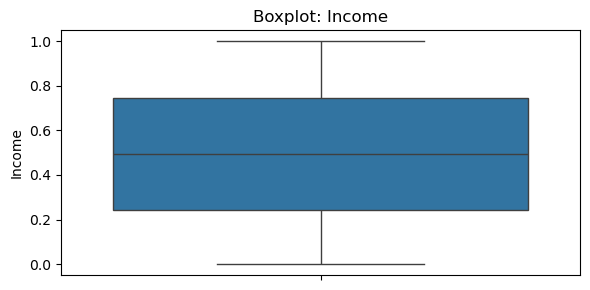

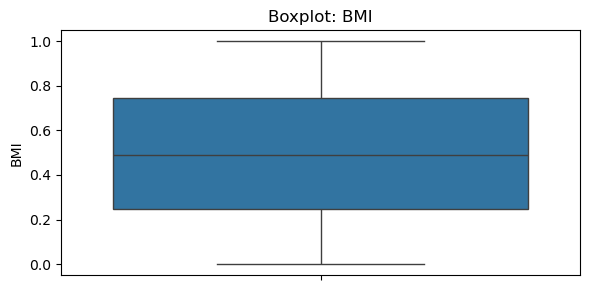

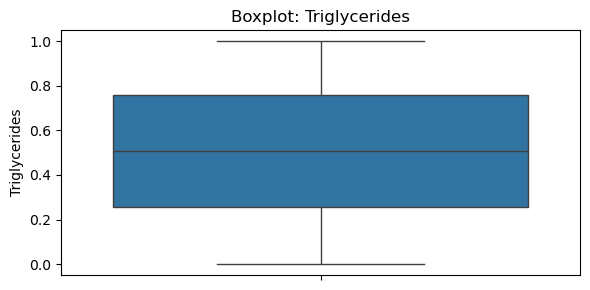

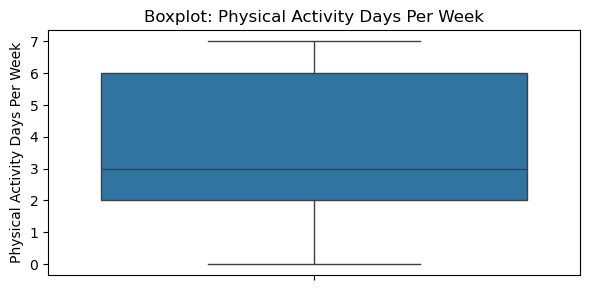

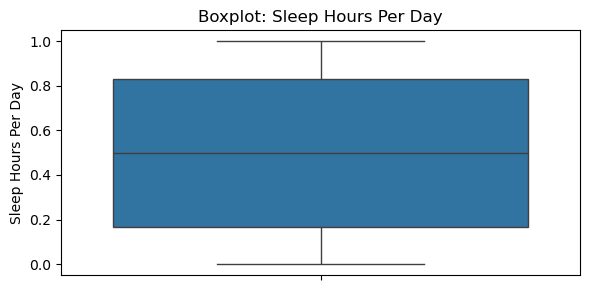

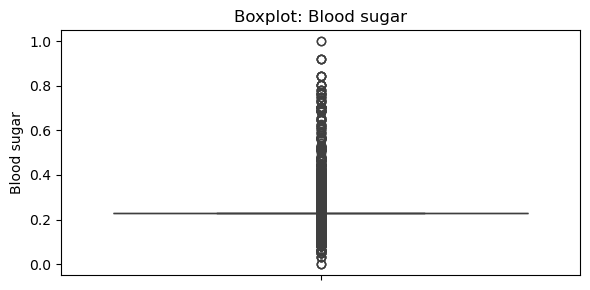

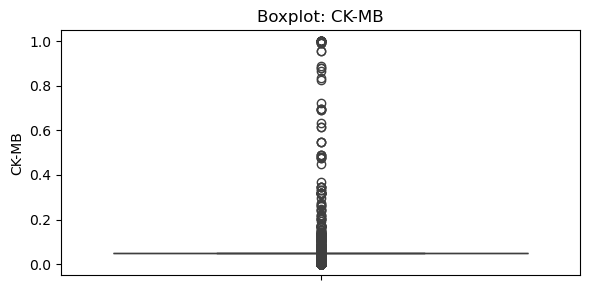

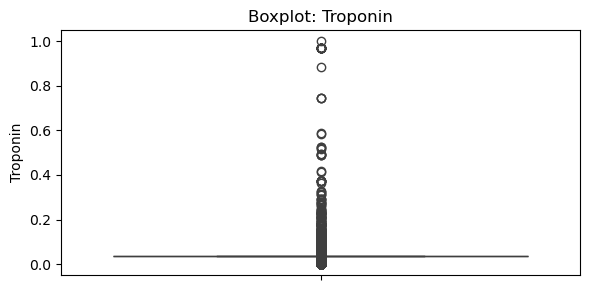

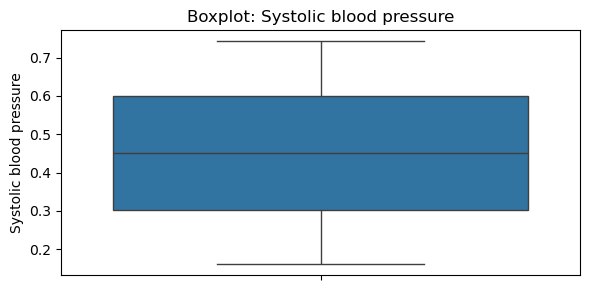

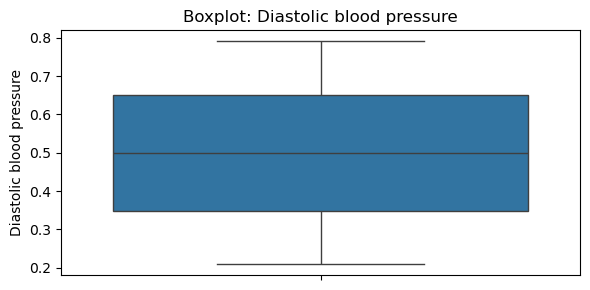

In [34]:
plot_boxplots(train_df, numeric_cols)

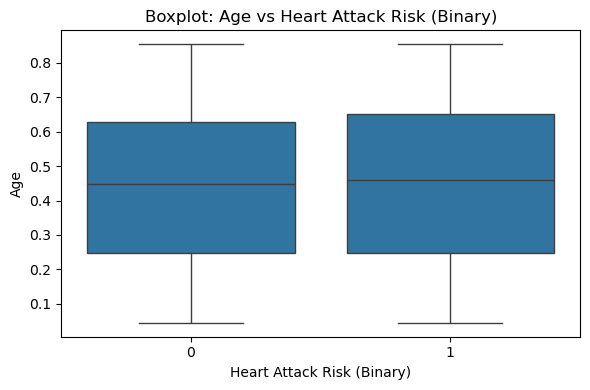

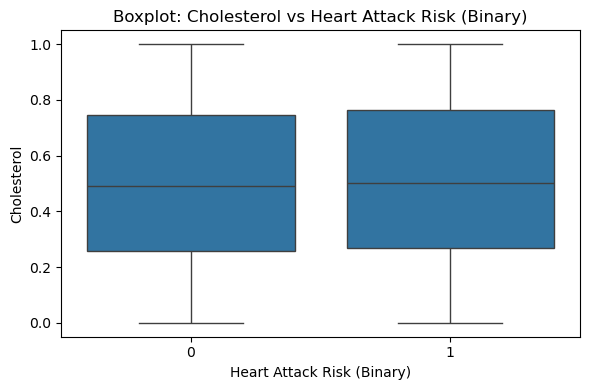

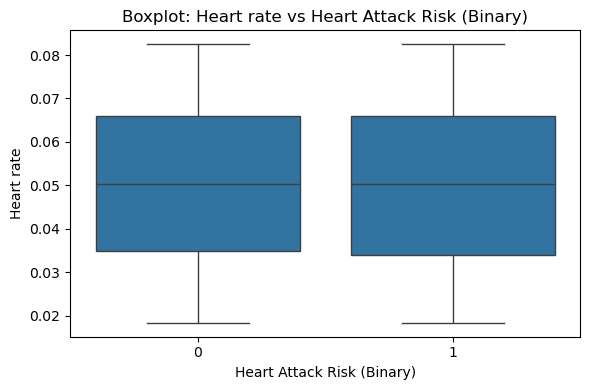

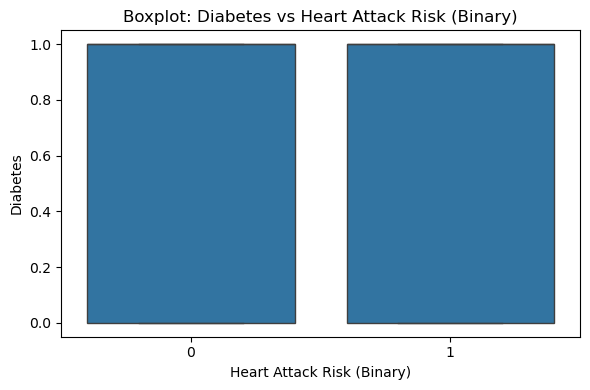

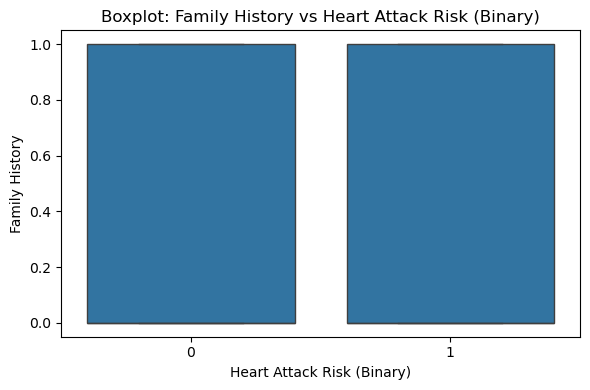

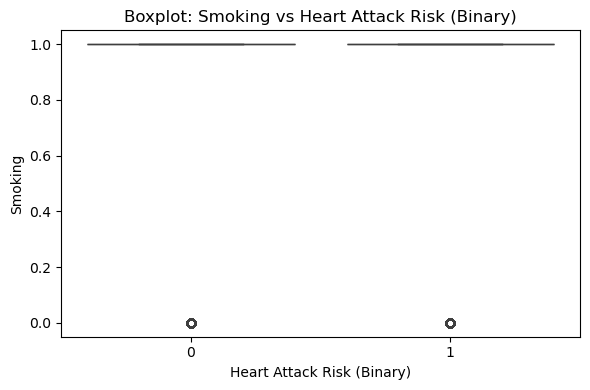

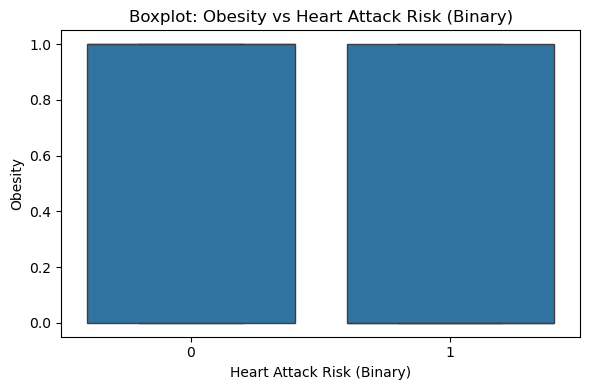

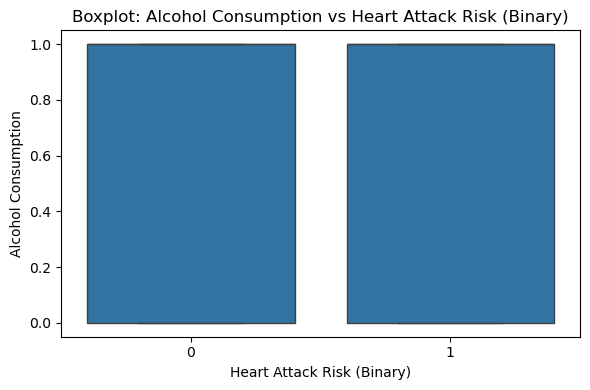

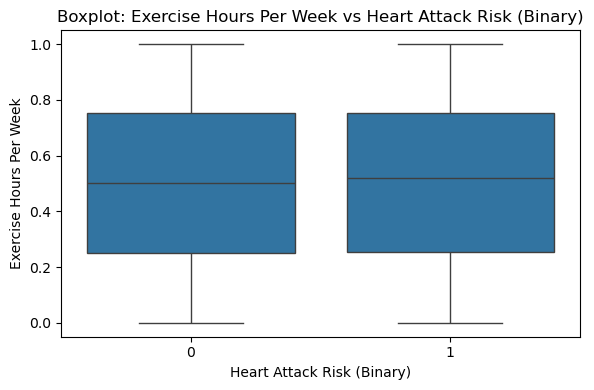

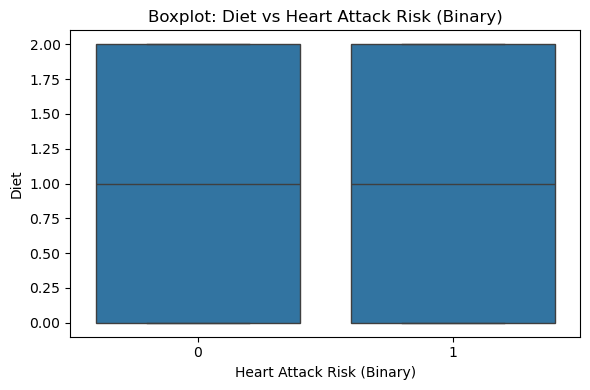

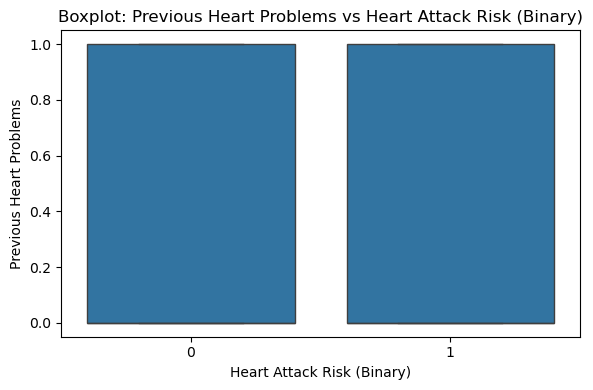

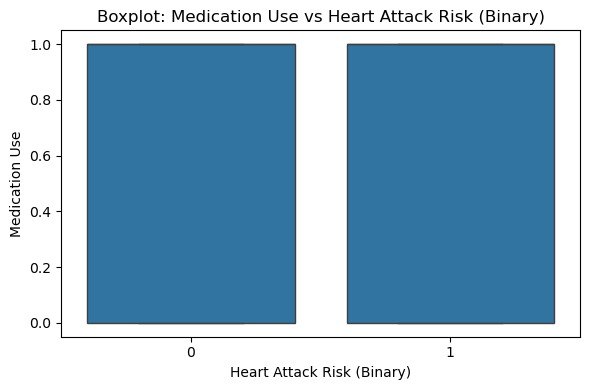

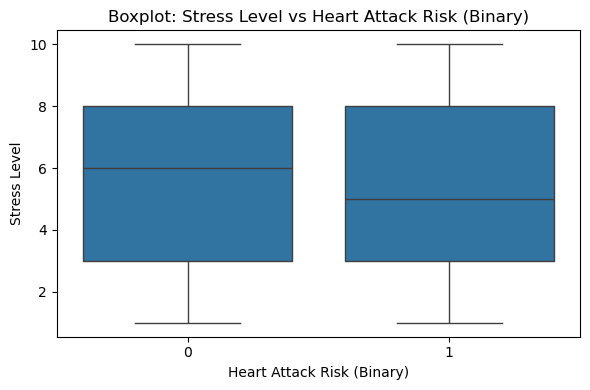

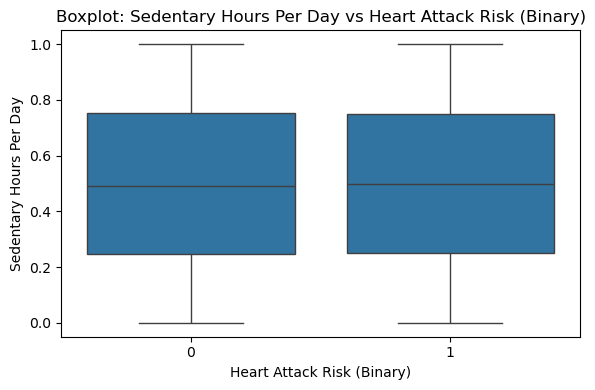

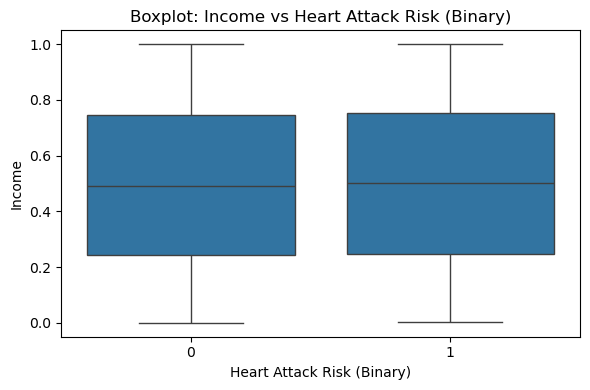

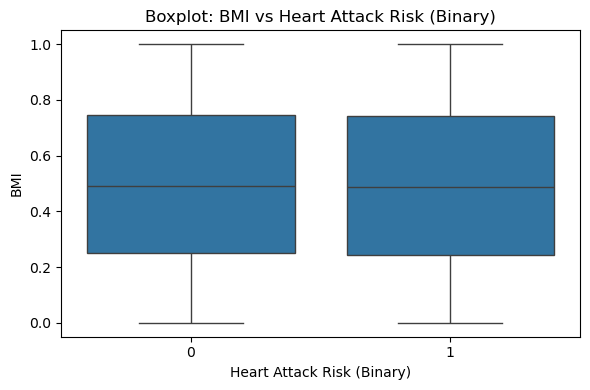

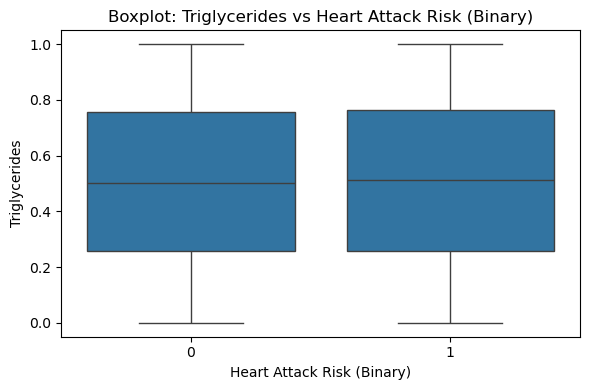

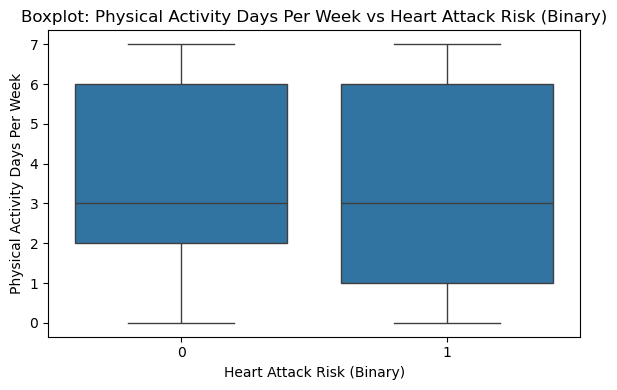

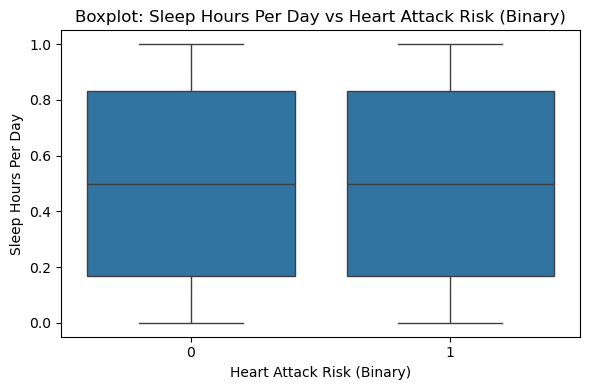

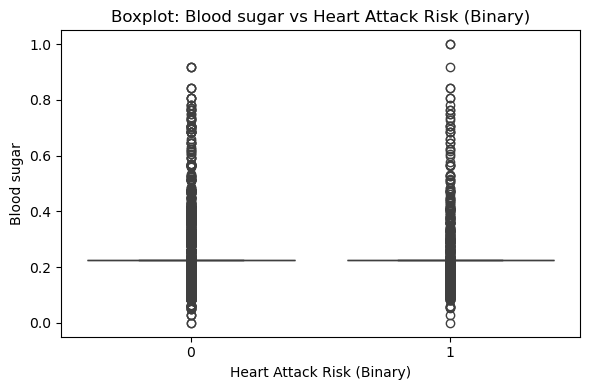

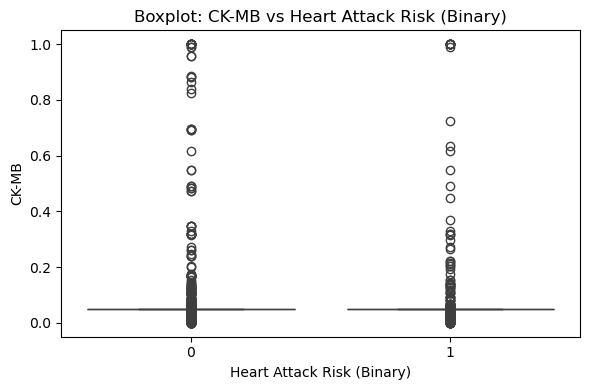

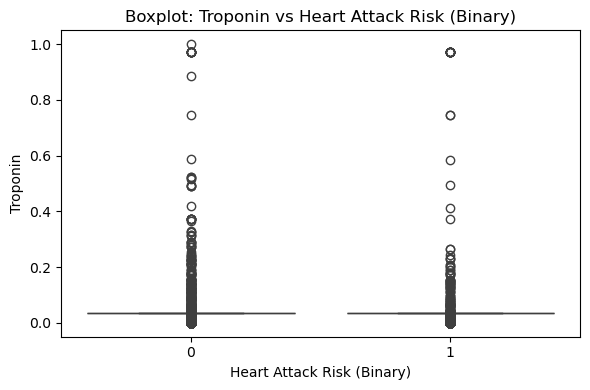

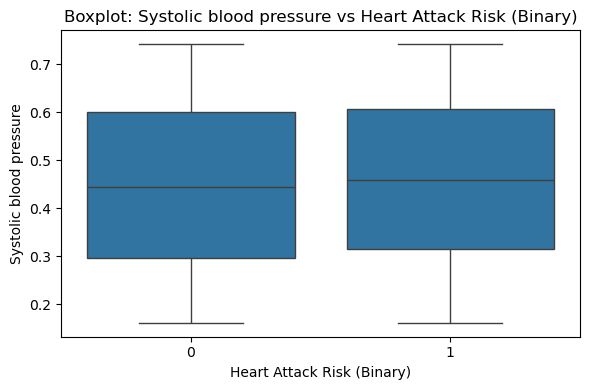

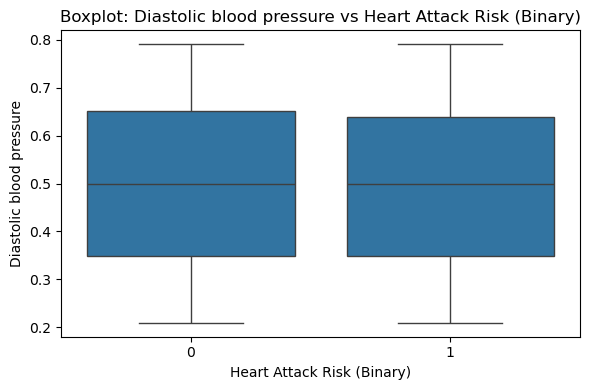

In [35]:
plot_boxplots_by_target(train_df, numeric_cols, 'Heart Attack Risk (Binary)')

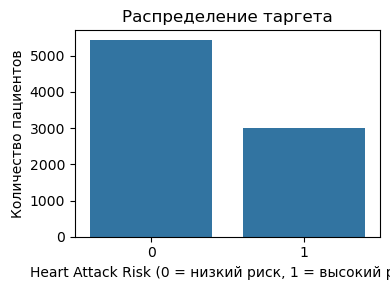

In [36]:
# И распределение таргета: 
plt.figure(figsize=(4, 3))
sns.countplot(x='Heart Attack Risk (Binary)', data=train_df)
plt.title('Распределение таргета')
plt.xlabel('Heart Attack Risk (0 = низкий риск, 1 = высокий риск)')
plt.ylabel('Количество пациентов')
plt.tight_layout()
plt.show()

In [37]:
# Проверю были ли нормализованы небинарные признаки (на первый взгляд да):
non_binary_numeric_cols = [col for col in numeric_cols if col not in binary_cols]
display(len(non_binary_numeric_cols))
for col in non_binary_numeric_cols:
    min_val = train_df[col].min()
    max_val = train_df[col].max()
    print(f"{col}: min = {min_val:.3f}, max = {max_val:.3f}")

17

Age: min = 0.045, max = 0.854
Cholesterol: min = 0.000, max = 1.000
Heart rate: min = 0.018, max = 0.082
Exercise Hours Per Week: min = 0.000, max = 1.000
Diet: min = 0.000, max = 2.000
Stress Level: min = 1.000, max = 10.000
Sedentary Hours Per Day: min = 0.000, max = 1.000
Income: min = 0.000, max = 1.000
BMI: min = 0.000, max = 1.000
Triglycerides: min = 0.000, max = 1.000
Physical Activity Days Per Week: min = 0.000, max = 7.000
Sleep Hours Per Day: min = 0.000, max = 1.000
Blood sugar: min = 0.000, max = 1.000
CK-MB: min = 0.000, max = 1.000
Troponin: min = 0.000, max = 1.000
Systolic blood pressure: min = 0.161, max = 0.742
Diastolic blood pressure: min = 0.209, max = 0.791


Изучив графики тренировочного датасета, а также изучив данные, видно, что большинство днных уже нормализовано. Есть признаки: Diet, Stress Level, Physical Activity Days Per Week, которые явно не нормализованы, но их я буду использовать как категориальные для CatBoost модели. 

 По графикам: выбросов нет, большого влияния какого-то признака на таргет также не увидела. Там, где на boxplot значения похожи на выбросы, по факту они таковыми не являются, т.к. вполне может быть разброс этих признаков, удалять их нельзя, так как, например, для признака Blood sugar, в реальности может быть большой разброс значений, но для большинства пациентов он, допустим, в пределах норма, что и видно на графике. Выбросы - не аномалии. 

Далее посмотрю распределение тестового датафрейма

In [38]:
def hists(df, numeric_cols):
    for col in numeric_cols:
        plt.figure(figsize=(5, 2))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(col)
        plt.tight_layout()
        plt.show()

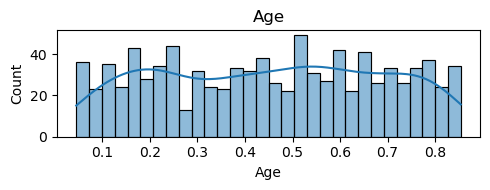

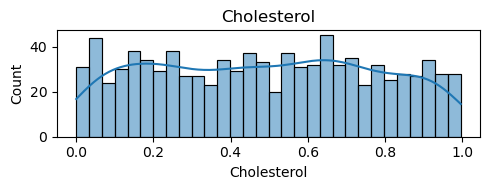

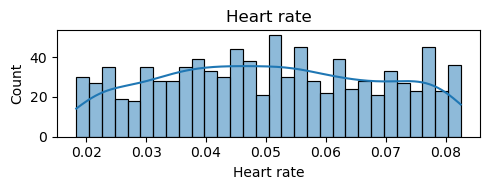

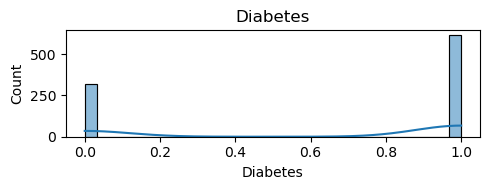

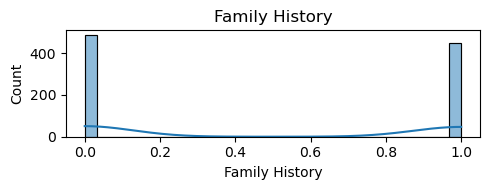

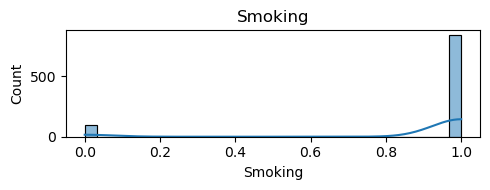

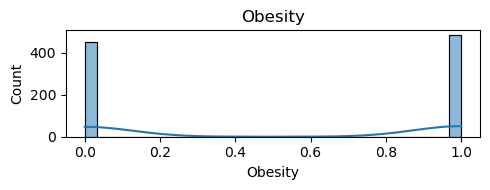

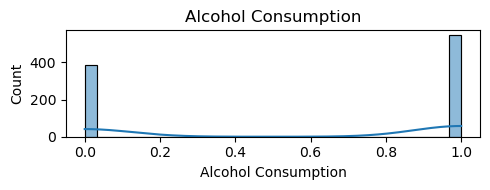

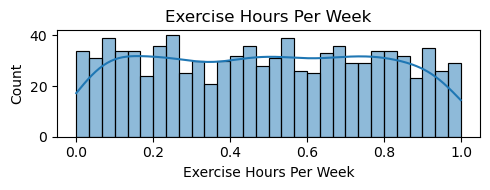

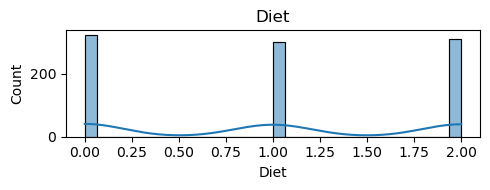

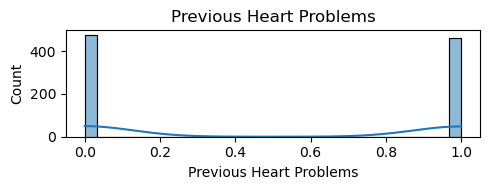

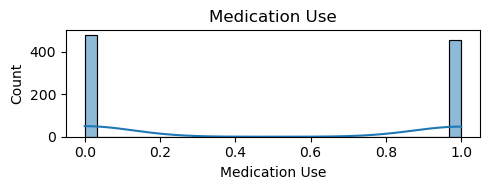

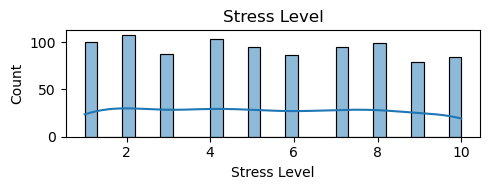

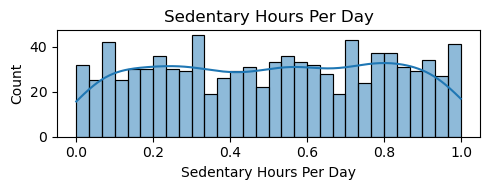

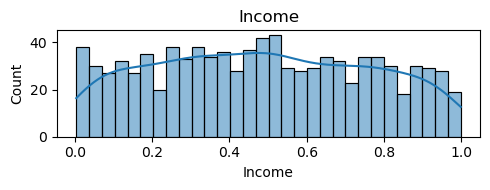

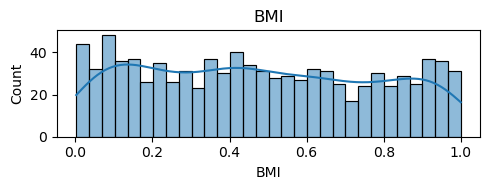

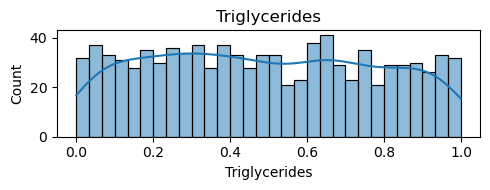

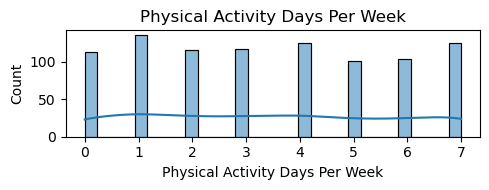

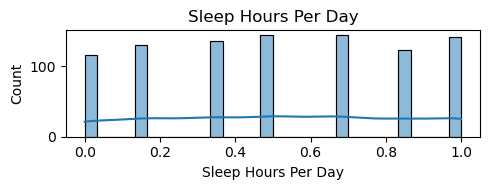

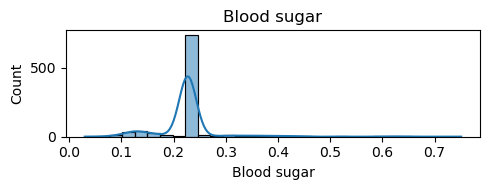

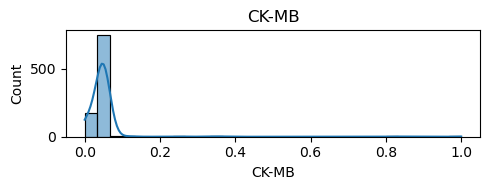

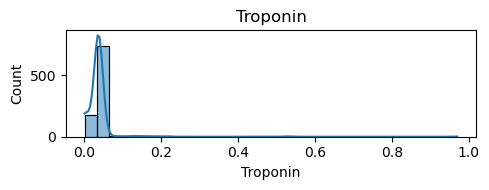

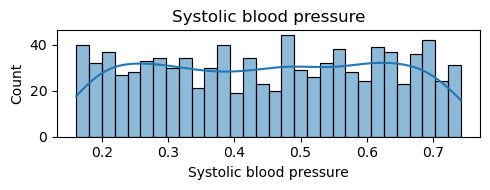

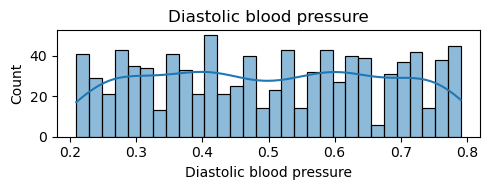

In [39]:
hists(test_df, numeric_cols)

In [40]:
def plot_boxplots(df, numeric_cols):
    for col in numeric_cols:
        plt.figure(figsize=(6, 3))
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot: {col}')
        plt.tight_layout()
        plt.show()

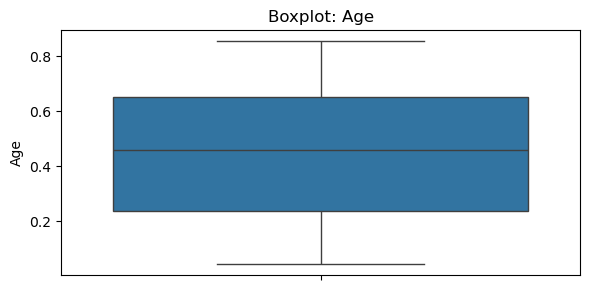

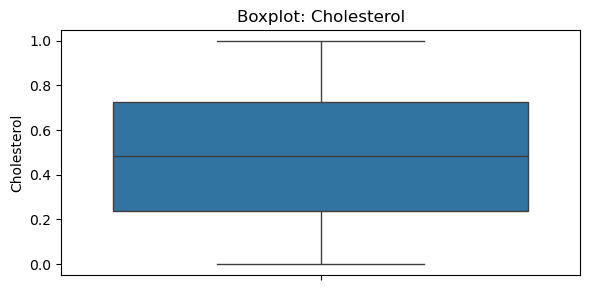

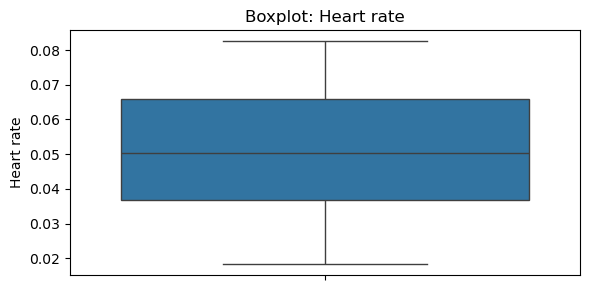

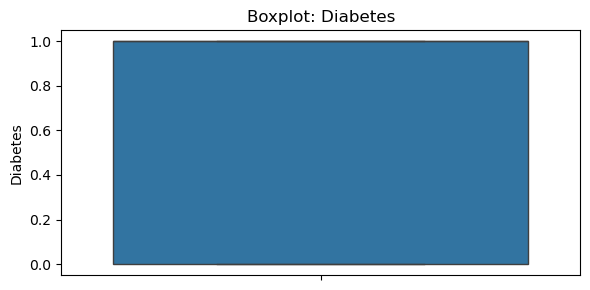

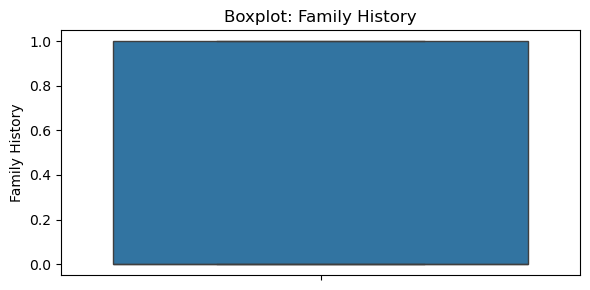

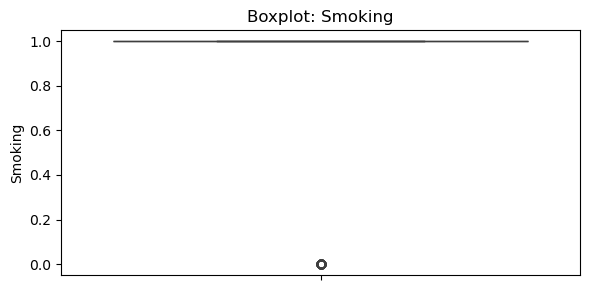

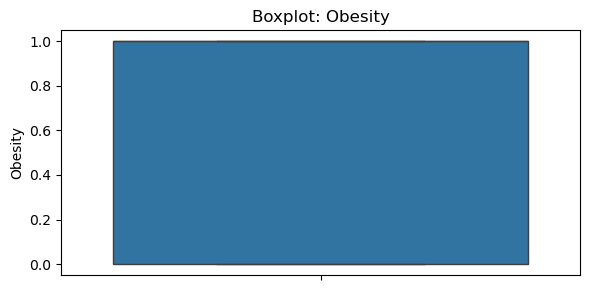

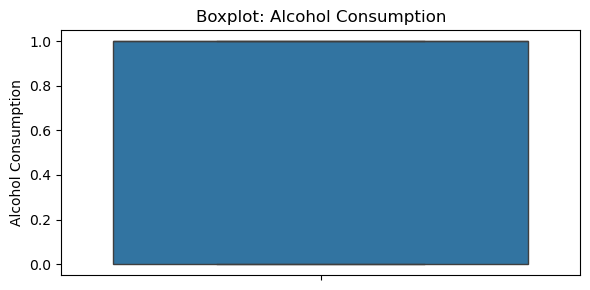

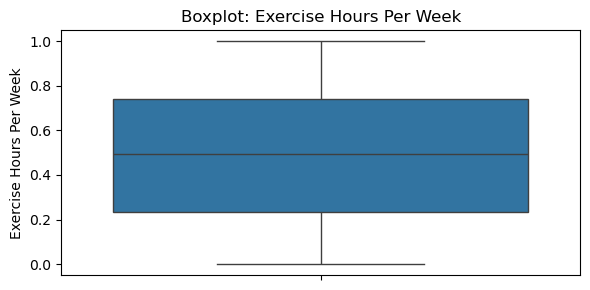

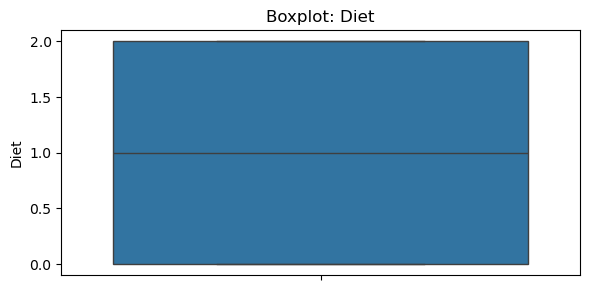

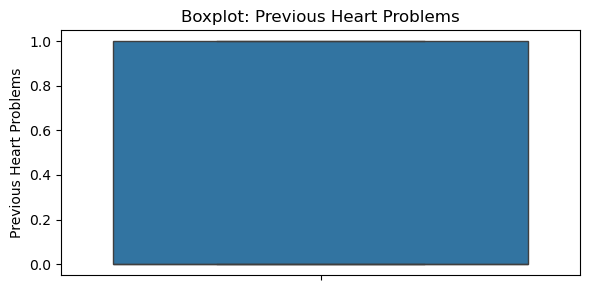

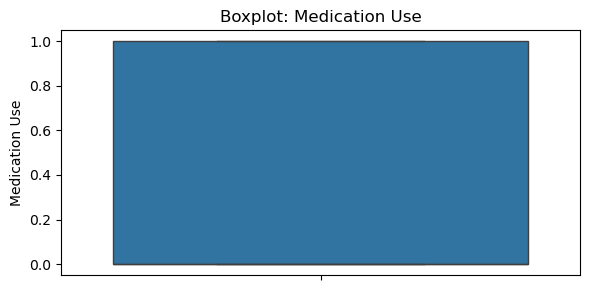

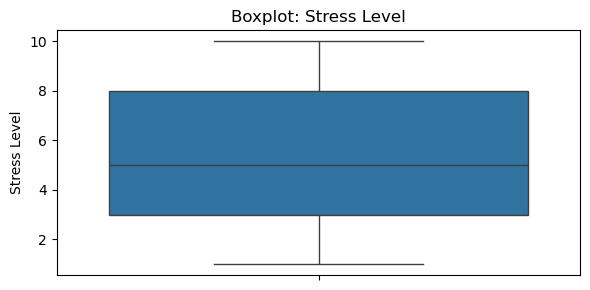

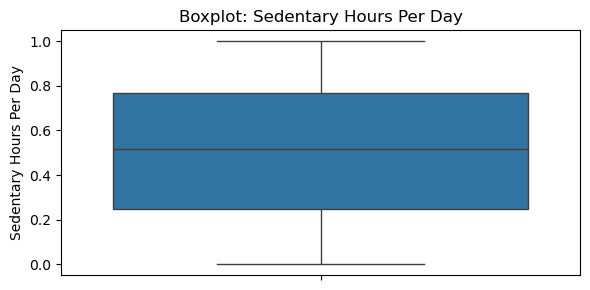

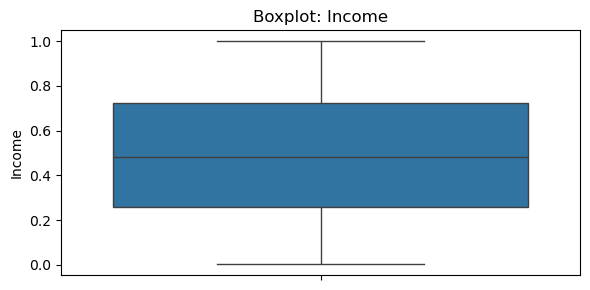

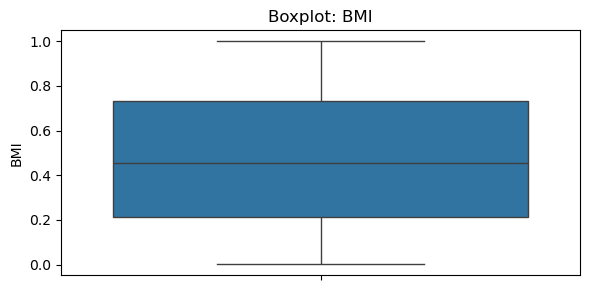

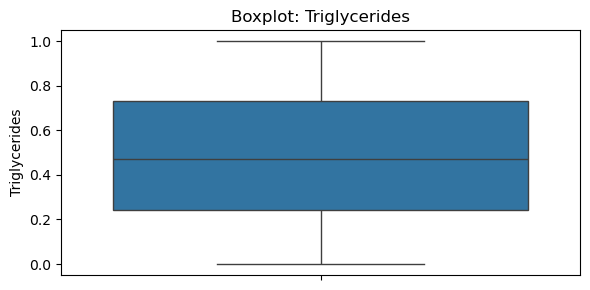

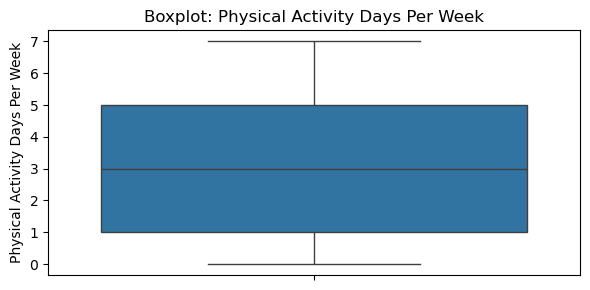

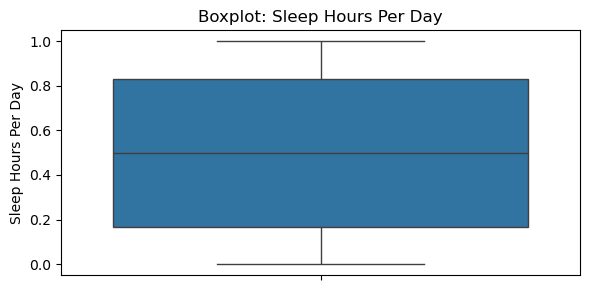

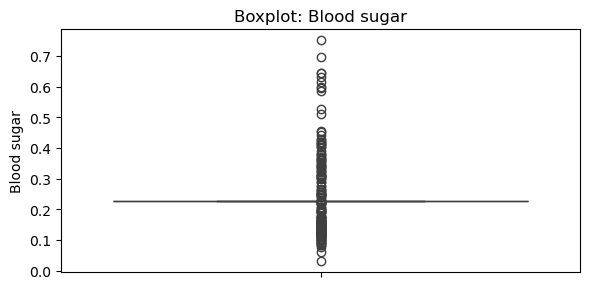

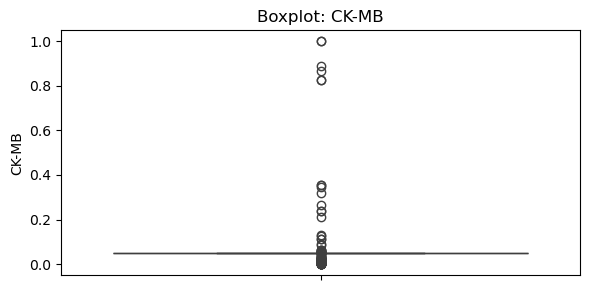

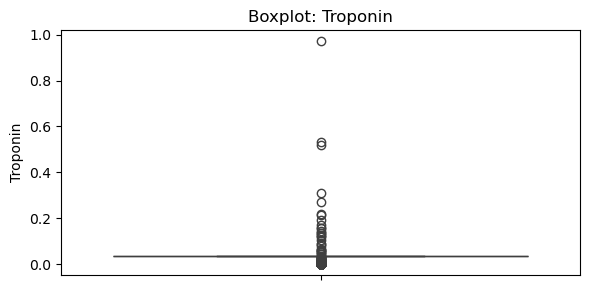

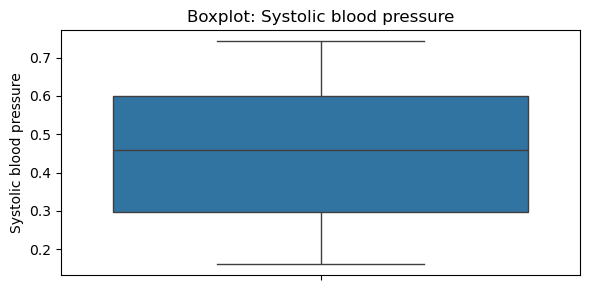

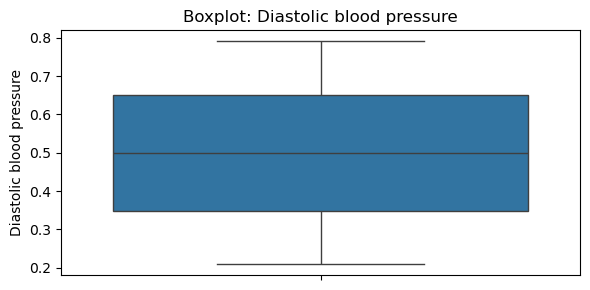

In [41]:
plot_boxplots(test_df, numeric_cols)

In [42]:
non_binary_numeric_cols = [col for col in numeric_cols if col not in binary_cols]
display(len(non_binary_numeric_cols))
for col in non_binary_numeric_cols:
    min_val = test_df[col].min()
    max_val = test_df[col].max()
    print(f"{col}: min = {min_val:.3f}, max = {max_val:.3f}")

17

Age: min = 0.045, max = 0.854
Cholesterol: min = 0.000, max = 0.996
Heart rate: min = 0.018, max = 0.082
Exercise Hours Per Week: min = 0.000, max = 0.999
Diet: min = 0.000, max = 2.000
Stress Level: min = 1.000, max = 10.000
Sedentary Hours Per Day: min = 0.001, max = 0.999
Income: min = 0.003, max = 0.999
BMI: min = 0.003, max = 0.999
Triglycerides: min = 0.000, max = 0.999
Physical Activity Days Per Week: min = 0.000, max = 7.000
Sleep Hours Per Day: min = 0.000, max = 1.000
Blood sugar: min = 0.030, max = 0.751
CK-MB: min = 0.000, max = 1.000
Troponin: min = 0.000, max = 0.971
Systolic blood pressure: min = 0.161, max = 0.742
Diastolic blood pressure: min = 0.209, max = 0.791


 По тестовому датасету та же картина, выбросов нет, данные почти все нормализованы, за исключением Diet, Stress Level, Physical Activity Days Per Week как в датасате выше. Они пойдут как категориальные для CatBoost

### Корреляционный анализ данных

Посмотрю корреляцию признаков в первом датасете

In [43]:
train_df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,1,0,8,0.225704,0.105948,0.459176,0.979221,3,0.333333,0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,1,0,9,0.289923,0.164217,0.117053,0.515584,3,0.833333,0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,1,1,6,0.550133,0.598745,0.373574,0.012987,2,1.000000,0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,0,1,3,0.330962,0.077605,0.049735,0.131169,0,0.333333,1,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,0,0,8,0.524600,0.341960,0.830405,0.070130,5,1.000000,1,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [44]:
# Задам епрерывные признаки: 
interval_cols = ['Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Sleep Hours Per Day', 'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure', 'Diastolic blood pressure']   
train_df_for_phik = train_df.drop('id', axis=1)
phik_matrix = train_df_for_phik.phik_matrix(interval_cols=interval_cols)


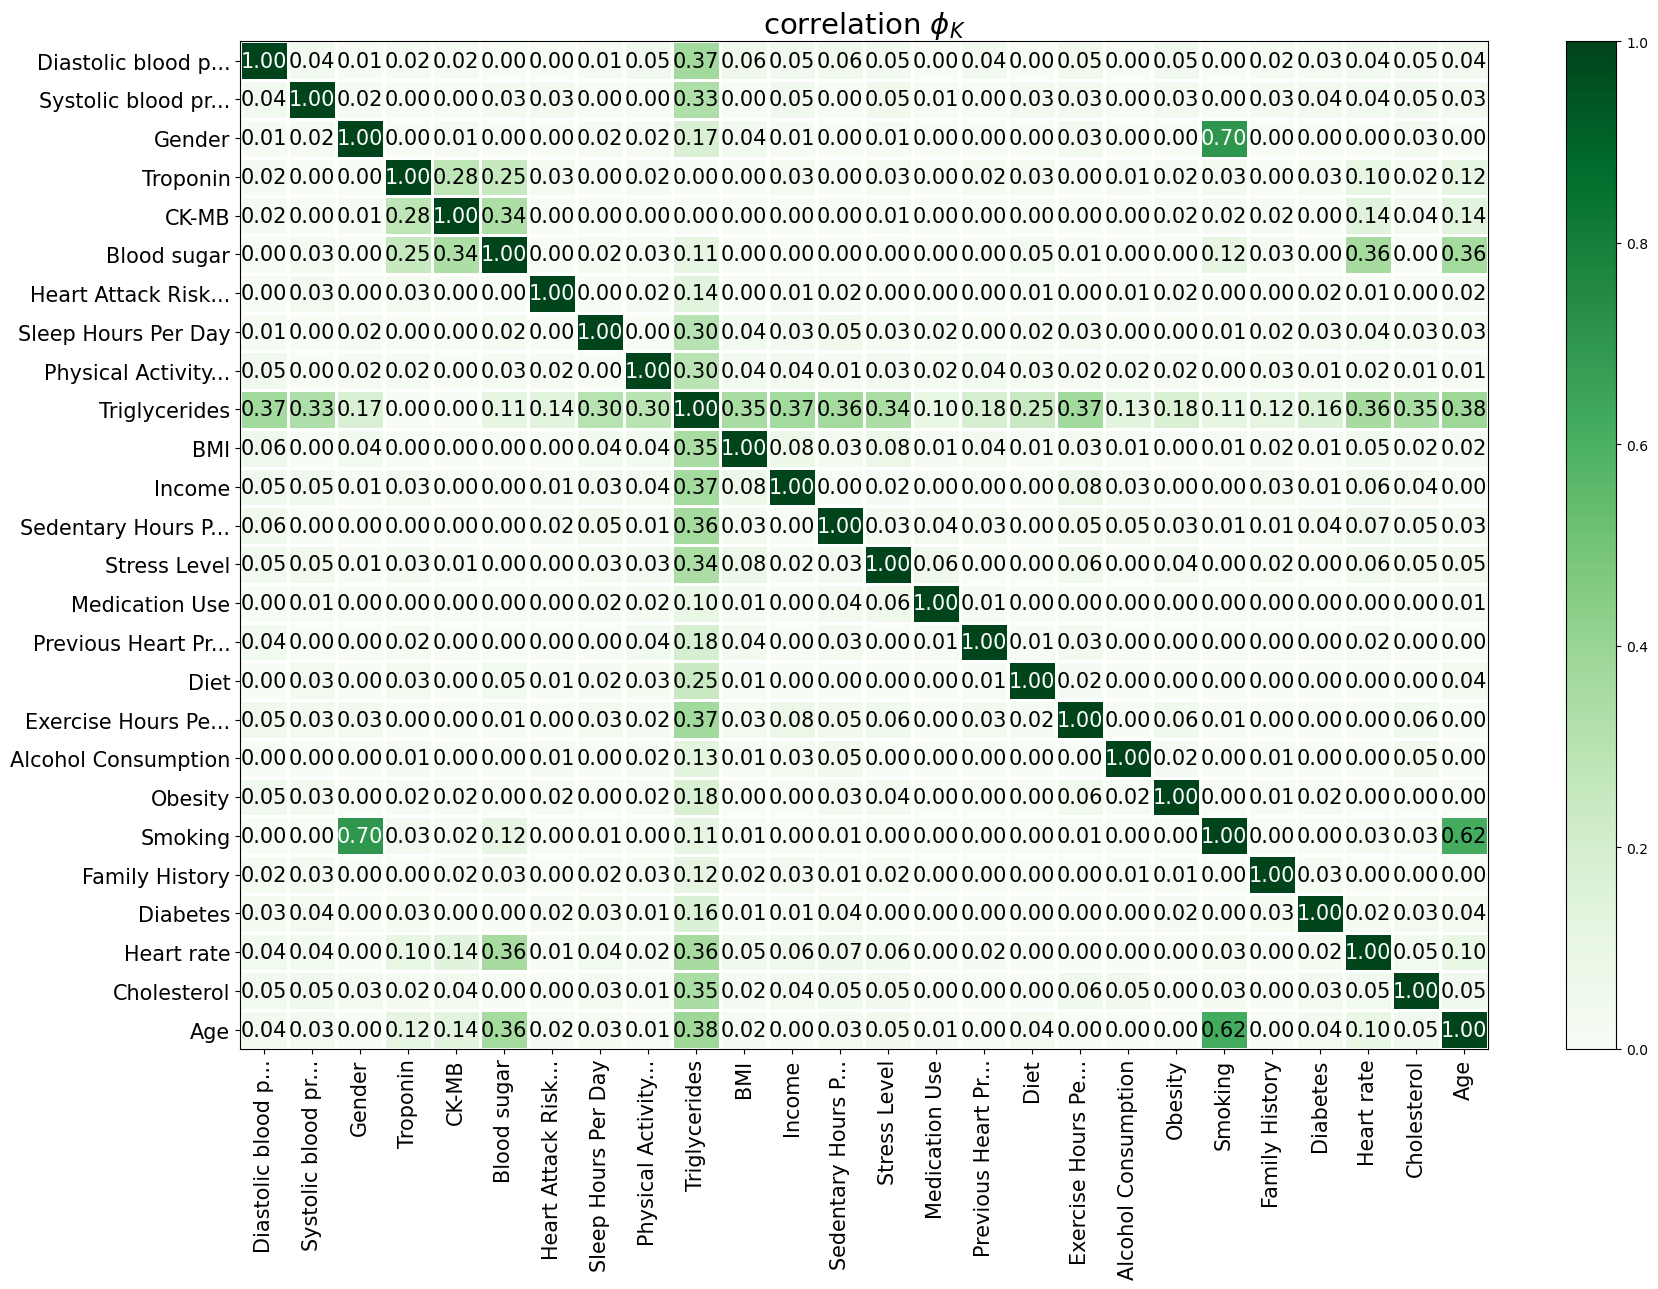

In [45]:
n = len(phik_matrix.columns)
figsize = (max(10, n * 0.7), max(8, n * 0.5))
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=figsize 
) 

Мультиколлинеарности в признаках не наблюдаю. Отмечу, что у всех признаков низкая корреляция с таргетом, однако на этом этапе я не могу сказать, что какой-то признак бесполезен, так как есть небольшая зависимость признаков между собой. 

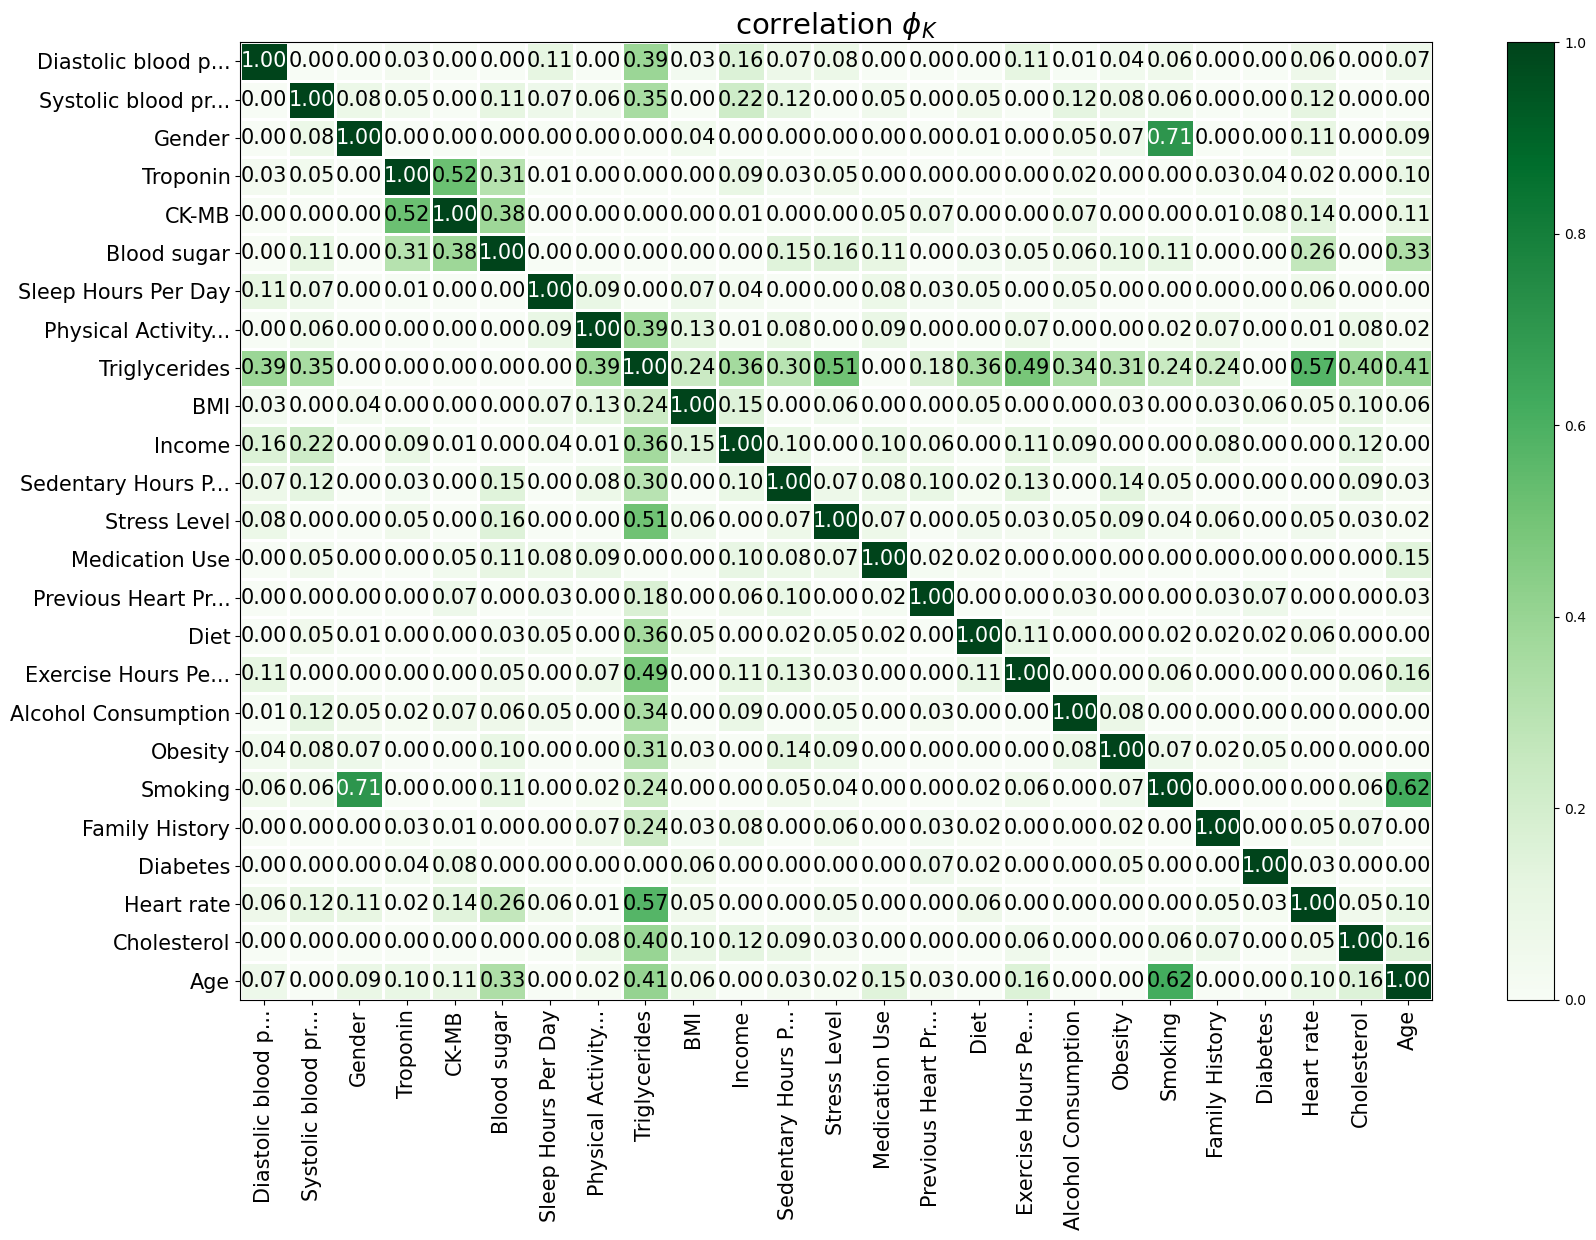

In [46]:
interval_cols = ['Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Sleep Hours Per Day', 'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure', 'Diastolic blood pressure']   
test_df_for_phik = test_df.drop('id', axis=1)
phik_matrix = test_df_for_phik.phik_matrix(interval_cols=interval_cols)

n = len(phik_matrix.columns)
figsize = (max(10, n * 0.7), max(8, n * 0.5))
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=figsize 
)

В тестовом датасете также нет мультиколлинеарности. 

**ВЫВОД** по разделу предобработки данных: 

В ходе предобработки были удалены пропуски, и заменены некоторые типы данных в обоих датасетах. Данные в датасетах содержат уже нормализованные значения и  изучив распределение на графиках могу предполагать, что значения, отмеченные на графиках как выбросы - не аномалии. 

В задании сказано, что в данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака. Однако мультиколлинеарности я не вижу, утечек по смыслу тоже вроде нет. Есть признаки типо Troponin, CK-MB, которые являются маркерами повреждения сердца, однако эти анализы могут назначать человеку и без инфаркта. И хотя эти кардиомаркеры в основном используются для диагностики инфаркта, их повышенные уровни также могут свидетельствовать о других состояниях, таких как миокардит, тромбоэмболия легочной артерии, острая сердечная недостаточность, сепсис, почечная недостаточность и другие.  

На графиках я посмотрела распределение признаков тренировочного датасета относительно таргета и видно, что ни один не выбивается по значениям, то есть опять же сильно скореллированных признаков нет.

Про бесполезность признаков посмотрю чуть далее на важности признаков модели после построения модели.

## Обучение модели

In [47]:
train_df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,1,0,8,0.225704,0.105948,0.459176,0.979221,3,0.333333,0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,1,0,9,0.289923,0.164217,0.117053,0.515584,3,0.833333,0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,1,1,6,0.550133,0.598745,0.373574,0.012987,2,1.000000,0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,0,1,3,0.330962,0.077605,0.049735,0.131169,0,0.333333,1,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,0,0,8,0.524600,0.341960,0.830405,0.070130,5,1.000000,1,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [48]:
#Явно укажу категориальные признаки:
cat_features = ['Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 'Gender']

Я выбрала для оценки метрику F1-меру, так как в целевом признаке есть дисбаланс классов. Класс 0 содержит данных чуть ли не в половину больше, чем класс 1. И я считаю, что важно одинаково учитывать как ложноположительные, так и ложноотрицательные прогнозы. Несмотря на то, что важно не упустить потенциального пациента с риском инфаркта, ложноположительные результаты также ни к чему хорошему не приведут, человек потратит кучу денег на обследования, будет много нервничать, что в свою очередь пагубно будет влиять на его здоровье вцелом. Да и врачу возиться с кучей ложно положительных пациентов и тяжело, и скажется на его репутации как некомпетентного врача.

In [49]:
# Сначала сбалансирую классы для построения модели:
df_majority = train_df[train_df['Heart Attack Risk (Binary)'] == 0]
df_minority = train_df[train_df['Heart Attack Risk (Binary)'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Разделю  на X и y
X_train_bal = df_balanced.drop(columns=['Heart Attack Risk (Binary)', 'id'])
y_train_bal = df_balanced['Heart Attack Risk (Binary)']

# Модель 
model_balanced = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    verbose=0
)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_bal, y_train_bal, test_size=0.2, random_state=42, stratify=y_train_bal
)

model_balanced.fit(X_train_sub, y_train_sub, cat_features=cat_features)

predictions = model_balanced.predict(X_val)
print("F1-score:", f1_score(y_val, predictions))

F1-score: 0.7139709122961657


In [50]:
# Сохраню модель
model_balanced.save_model("catboost_heart_model.cbm")

In [51]:
# Сделаю предсказания на тестовой выборке:
X_test = test_df.drop(columns=['id'])
predictions = model_balanced.predict(X_test)

submission = pd.DataFrame({
    'id': test_df['id'],
    'prediction': predictions.astype(int)
})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,prediction
0,7746,0
1,4202,0
2,6632,0
3,4639,0
4,4825,1


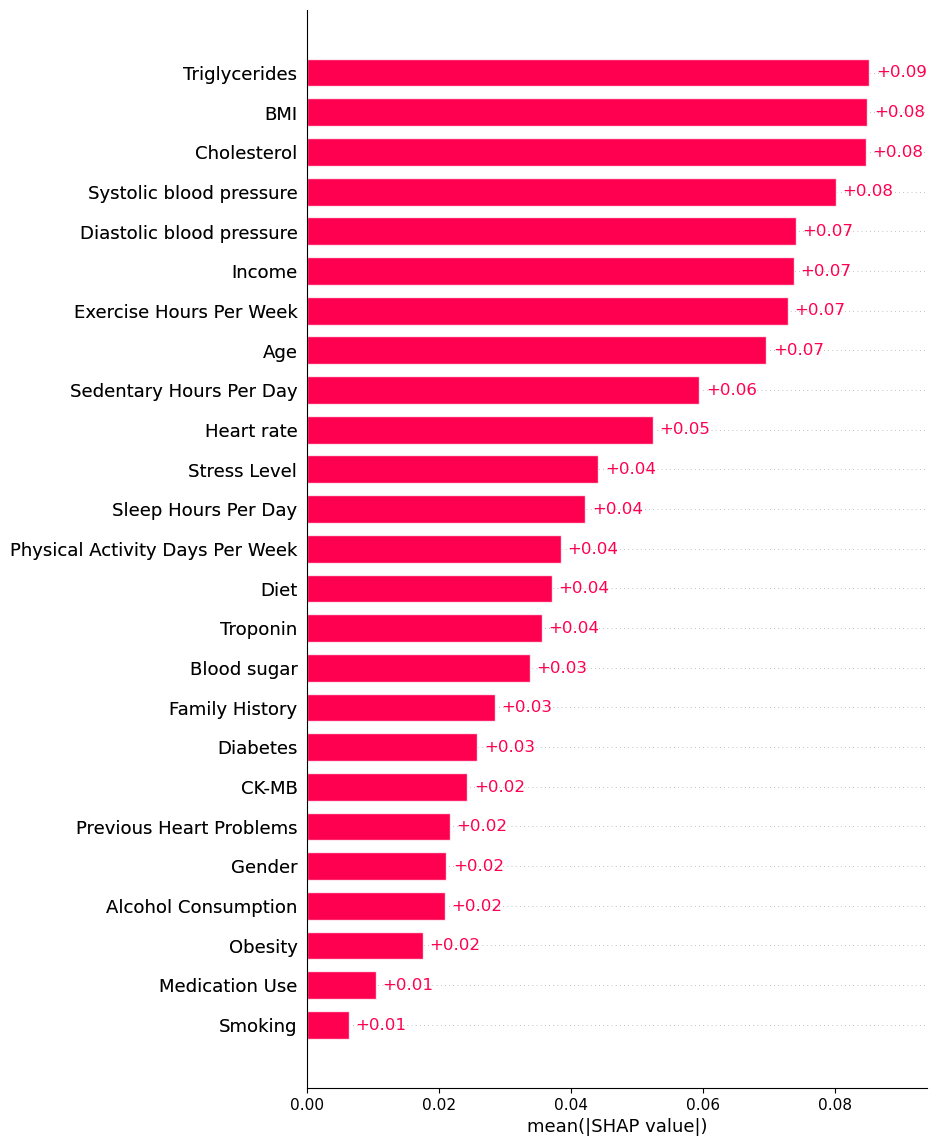

In [52]:
# Посмотрю важность признаков методом Shap:
explainer = shap.TreeExplainer(model_balanced)
shap_values = explainer(X_train_sub)
shap.plots.bar(shap_values, max_display=len(X_train_sub.columns))

Изучила важность признаков. Наиболее важными модель считает: Triglycerides, BMI, Cholesterol, blood pressure. И очень малозначимыми считает Medication Use и Smoking, однако бесполезными эти признаки назвать не могу. Поэтому на мой взгляд для удаление из датасета каких-то признаков нет предпосылок. Тем более метрика F1 уже неплохая. Явного влияния одного признака не наблюдается. Конечно всегда есть к чему стремиться, но я пока остановлюсь на таком варианте работы модели.

## ВЫВОДЫ

В ходе работы не так много я изменила в исходных датасетах. Поработала с типом данных, убрала пропуски, но не удаляла признаки, т.к. не нашла ни мультиколлинеарности, ни особо бесполезных признаков, ни утечки данных. Тем я пробовала разные варианты перебора параметров модели, но результат оказался хуже: видимо переобучила модель или еще что-то, поэтому я просто сбалансировала классы и подобрала вручную наилучшие параметры модели. Использовала валидационную выборку из тренировочного датасета для оценки метрики качества. Результатом работы модели является предсказание высокого или низкого риска поражения сердца. 